<a href="https://colab.research.google.com/github/vamuth/Codebase_Thesis/blob/master/license_plate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import io_utils
#from loss_fourier import *
#from loss_spherical import *

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math as m
import os
import cv2

from torch.autograd import Variable
import torchvision
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchsummary import summary
from torchvision import models
import csv

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
#!rm -rf sample_data/train/
#!rm -rf sample_data/validation/
#!unzip sample_data/Synthetic_Plates.zip

In [3]:
train_folder_synthetic= "sample_data/Synthetic_Plates/train"
test_folder_synthetic= "sample_data/Synthetic_Plates/validation"
train_folder_real = "sample_data/Real_Plates/train"
test_folder_real = "sample_data/Real_Plates/validation"

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    device='cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device='cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
## Prepare dataset from raw images and labels
### read all images from the folder and reshape to same size
### clean any wrong labels 

def prepare_dataset(folder):
  images = []
  labels = []
  

  for filename in os.listdir(folder):
  
    img = (cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE))
    #filename = filename.replace('Щ', 'Ö').replace('Ъ', 'Ü')#.replace('Ъ', 'Ü')
    label = filename.find('_')

    if (img is not None) and (label >0 and label < 4):

      # Prepare the labels 
      labels.append(label)

      # Make sure image is of same size and resize it
      img = cv2.resize(img, (200,40), interpolation = cv2.INTER_AREA)
      images.append(img)


  data = torch.tensor(np.array(images).astype('float32'))#/255
  label = torch.tensor(np.array(labels).astype('long'))


  return data, label

In [6]:
traindata, trainlabel = prepare_dataset(train_folder_synthetic)
testdata, testlabel = prepare_dataset(test_folder_synthetic)

train_dataset = torch.utils.data.TensorDataset(traindata, trainlabel)
test_dataset = torch.utils.data.TensorDataset(testdata, testlabel)

# train_size = int(1.0 *len(train_dataset))
# validation_size = len(train_dataset) - train_size


#train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, validation_size])
batch_size = 64

dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
#dataloaders['validation'] = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
dataloaders['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=1)

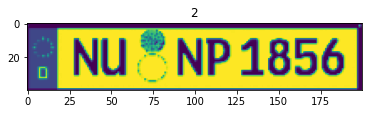

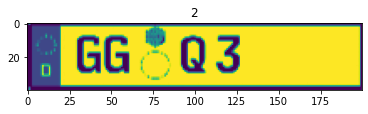

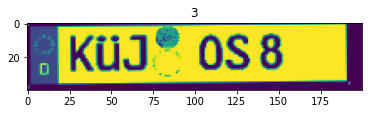

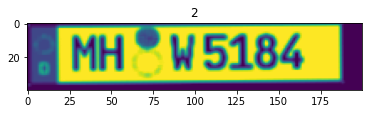

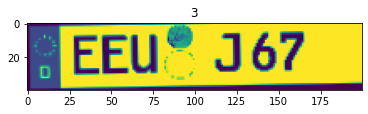

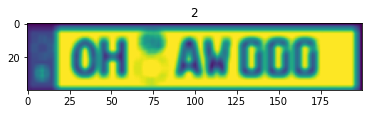

In [7]:

for i, (observations, labels) in enumerate(dataloaders['train']):

    plt.imshow(observations[i,:,:])
    plt.title(str(labels[i].numpy()))
    plt.show()
    if (i == 5):
      break

In [8]:
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)       
model.fc = nn.Linear(in_features=512, out_features=3, bias=True)


In [9]:
model.to(device)
print(model)
learning_rate = 0.25
#criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), learning_rate)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1 - Training Loss : 2.1990 
Epoch 2 - Training Loss : 0.6050 
Epoch 3 - Training Loss : 0.1005 
Epoch 4 - Training Loss : 0.0258 
Epoch 5 - Training Loss : 0.0165 
Epoch 6 - Training Loss : 0.0166 
Epoch 7 - Training Loss : 0.0064 
Epoch 8 - Training Loss : 0.0103 
Epoch 9 - Training Loss : 0.0022 
Epoch 10 - Training Loss : 0.0012 
Epoch 11 - Training Loss : 0.0008 
Epoch 12 - Training Loss : 0.0000 
Epoch 13 - Training Loss : 0.0000 
Epoch 14 - Training Loss : 0.0000 
Epoch 15 - Training Loss : 0.0000 


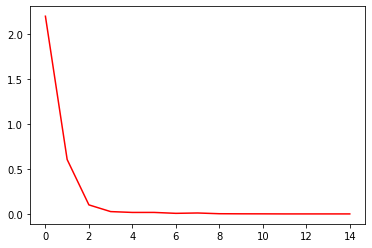

In [10]:
#### Train Resnet without pretrained weights using Synthetic dataset


train_losses = []
validation_losses = []
test_accuracies=[]


epochs = 15
for epoch in range(epochs):
    model.train()
    batch_train_losses =[]
    batch_val_losses = []
    
    for i, (observations, labels) in enumerate(dataloaders['train']):
        
        
        # Forward pass
        optimizer.zero_grad()
        observations = observations.unsqueeze(1)
        outputs = model(observations.to(device))
        
        # Backward pass
        labels -= 1
        loss= criterion(outputs, labels.to(device))
        loss.backward()
        
        
        # Optimize
        optimizer.step()
        
        # Accumulate losses
        batch_train_losses.append(loss.cpu().detach().numpy())
        
        
    # # Testing on validation data
    # model.eval()
    
    # correct = 0
    # total = 0
    
    # with torch.no_grad():
    #   for i,(observations, labels) in enumerate(dataloaders['test']):
          
    #       # Forward pass
    #       observations = observations.unsqueeze(1)
    #       outputs = model(observations.to(device))
          
    #       # Loss calculation, No Backward pass
    #       labels -= 1
    #       loss = criterion(outputs, labels.to(device))
          
    #       # Accumulate losses
    #       batch_val_losses.append(loss.cpu().detach().numpy())
          
    #       #Calculate accuracy
    #       _,predicted = torch.max(outputs.data, 1)
    #       correct += (predicted.cpu() == labels).sum().item()
    #       total += labels.size(0)
          
    #Accumulate train and validation loss/accuracy for the epoch
    train_losses.append(np.mean(batch_train_losses))
    #   validation_losses.append(np.mean(batch_val_losses))
      
    #   accuracy = 100 * correct/total
    #   test_accuracies.append(accuracy)
    
    
    #print('Epoch {} - Training Loss : {:.4f}, Testing Loss: {:.4f}, Test accuracy: {:.2f}% '\
    #      .format(epoch+1, np.mean(batch_train_losses), np.mean(batch_val_losses), accuracy))

    print('Epoch {} - Training Loss : {:.4f} '\
          .format(epoch+1, np.mean(batch_train_losses)))
        
    

fig, ax = plt.subplots()
ax.plot(train_losses, 'r', label='Training loss')
#ax.plot(validation_losses, 'g', label='Validation loss')

plt.show()

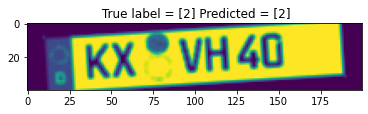

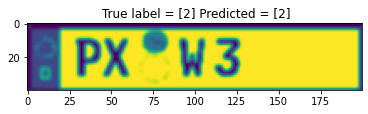

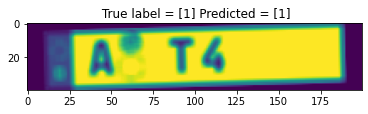

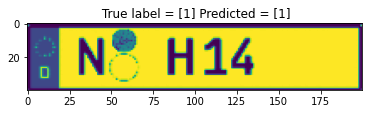

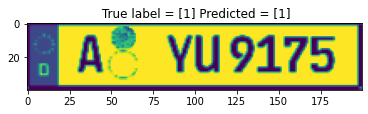

Test Accuracy:100.0


In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for i,(observations, labels) in enumerate(dataloaders['test']):
      
          # Forward pass
          observations = observations.unsqueeze(1)
          outputs = model(observations.to(device))
          
          # Loss calculation, No Backward pass
          labels -= 1
          #loss = criterion(outputs, labels.to(device))
          
          # Accumulate losses
          #batch_val_losses.append(loss.cpu().detach().numpy())
          
          #Calculate accuracy
          _,predicted = torch.max(outputs.data, 1)
          correct += (predicted.cpu() == labels).sum().item()
          total += labels.size(0)
  
          observations = observations.squeeze(1)

          if i<5:

            plt.imshow(observations[0,:,:])
            title = " True label = " + str(labels.detach().cpu().numpy()+1) + " Predicted = " + str(predicted.detach().cpu().numpy()+1)
            plt.title(title)
            plt.show()
          
          accuracy = 100 * correct/total
          test_accuracies.append(accuracy) 


  print("Test Accuracy:"  + str(np.mean(test_accuracies)))     



In [12]:
traindata, trainlabel = prepare_dataset(train_folder_real)
testdata, testlabel = prepare_dataset(test_folder_real)

train_dataset = torch.utils.data.TensorDataset(traindata, trainlabel)
test_dataset = torch.utils.data.TensorDataset(testdata, testlabel)

batch_size = 64

dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=1)

Epoch 1 - Training Loss : 2.4298 
Epoch 2 - Training Loss : 2.5381 
Epoch 3 - Training Loss : 1.5270 
Epoch 4 - Training Loss : 1.5148 
Epoch 5 - Training Loss : 0.9490 
Epoch 6 - Training Loss : 0.8667 
Epoch 7 - Training Loss : 0.8606 
Epoch 8 - Training Loss : 0.8636 
Epoch 9 - Training Loss : 0.8584 
Epoch 10 - Training Loss : 0.8541 


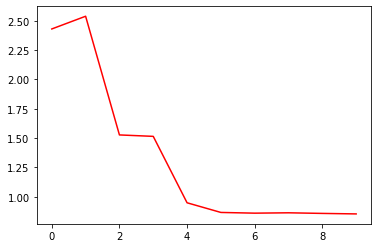

In [13]:
train_losses = []
validation_losses = []
test_accuracies=[]


epochs = 10
for epoch in range(epochs):
    model.train()
    batch_train_losses =[]
    batch_val_losses = []
    
    for i, (observations, labels) in enumerate(dataloaders['train']):
        
        
        # Forward pass
        optimizer.zero_grad()
        observations = observations.unsqueeze(1)
        outputs = model(observations.to(device))
        
        # Backward pass
        labels -= 1
        loss= criterion(outputs, labels.to(device))
        loss.backward()
        
        
        # Optimize
        optimizer.step()
        
        # Accumulate losses
        batch_train_losses.append(loss.cpu().detach().numpy())
        
        

    print('Epoch {} - Training Loss : {:.4f} '\
          .format(epoch+1, np.mean(batch_train_losses)))
        
    train_losses.append(np.mean(batch_train_losses))

fig, ax = plt.subplots()
ax.plot(train_losses, 'r', label='Training loss')
plt.show()

tensor([1], device='cuda:0')


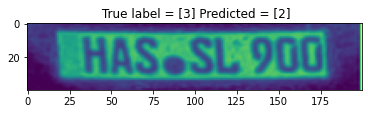

tensor([1], device='cuda:0')


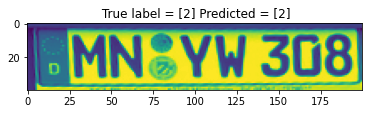

tensor([1], device='cuda:0')


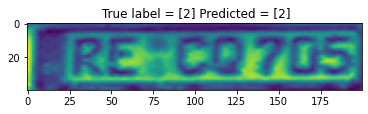

tensor([1], device='cuda:0')


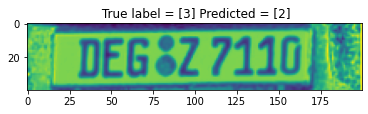

tensor([1], device='cuda:0')


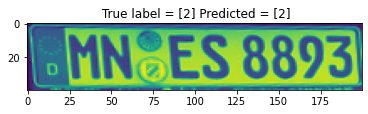

tensor([1], device='cuda:0')


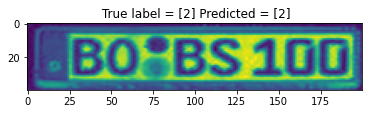

tensor([1], device='cuda:0')


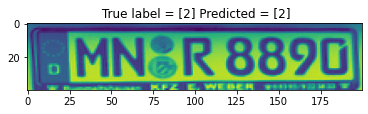

tensor([1], device='cuda:0')


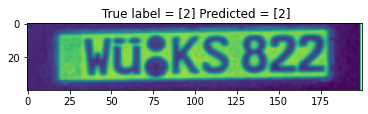

tensor([1], device='cuda:0')


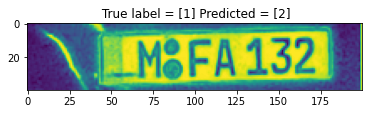

tensor([1], device='cuda:0')


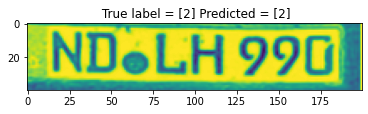

Average accuracy = 99.42113387188404
Max. accuracy =  99.70588235294117


In [14]:
model.eval()
averaged_accuracy = []
for trial in range(5):
  with torch.no_grad():
    for i,(observations, labels) in enumerate(dataloaders['test']):
        
            # Forward pass
            observations = observations.unsqueeze(1)
            outputs = model(observations.to(device))
            
            # Loss calculation, No Backward pass
            labels -= 1
            #loss = criterion(outputs, labels.to(device))
            
            # Accumulate losses
            #batch_val_losses.append(loss.cpu().detach().numpy())
            
            #Calculate accuracy
            _,predicted = torch.max(outputs.data, 1)
            correct += (predicted.cpu() == labels).sum().item()
            total += labels.size(0)
    
            observations = observations.squeeze(1)

            if trial == 2:
              plt.imshow(observations[0,:,:])
              print(predicted)
              title = " True label = " + str(labels.detach().cpu().numpy() +1) + " Predicted = " + str(predicted.detach().cpu().numpy() +1 )
              plt.title(title)
              plt.show()
            
    accuracy = 100 * correct/total
    test_accuracies.append(accuracy) 
    #print("Test Accuracy :" + str(np.mean(test_accuracies)))  
    averaged_accuracy.append(np.mean(test_accuracies))

print("Average accuracy =", str(np.mean(averaged_accuracy)) )
print("Max. accuracy = " , str(np.max(averaged_accuracy)))